In [1]:
import preprocess
import random
import pandas as pd
import json
import numpy as np
import scipy.sparse as sp
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rc
from matplotlib.colors import BoundaryNorm
rc('figure', figsize=(16, 8), max_open_warning=False)

from surprise import SVD, SVDpp, NMF
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import train_test_split

# Sparsity

In [2]:
# mydict = preprocess.create_paper_paper_dict()
# Creat random subset of dictionary, where we only retain references to themselves
random_dict = preprocess.create_random_subset_paper_paper_data()

In [3]:
numbering, reverse = dict(), dict()
current_id = 0

for i in random_dict.keys():
    numbering[i] = current_id
    reverse[current_id] = i
    current_id += 1

In [4]:
# Build paper-paper matrix to observe its sparsity
papernum = len(random_dict.keys())
papermat = sp.dok_matrix((papernum,papernum), dtype=np.int8)
for paper_id, ref_ids in random_dict.items():
    for ref in ref_ids:
        papermat[numbering[paper_id], numbering[ref]] = 1

sparsity:  0.00027456 %


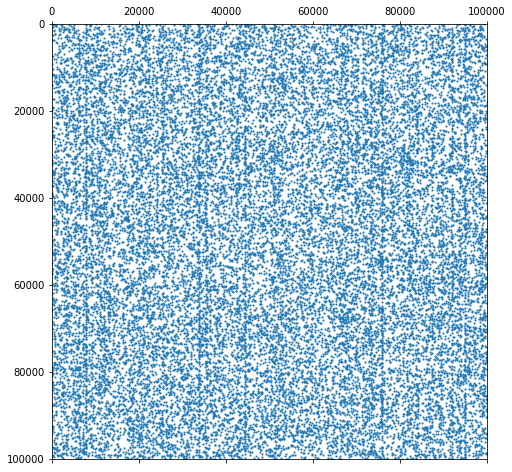

In [5]:
print("sparsity: ",100*papermat.count_nonzero()/papernum**2, "%")
plt.spy(papermat, markersize=1)
plt.show()

# SVD

In [6]:
data = preprocess.create_surprise_paper_paper_data(random_dict)

In [7]:
# split that data to train, test set and then do SVD
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD(biased=False)
algo.fit(trainset)
predictions = algo.test(testset)
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

In [23]:
for i in range(len(df.details)):
    if df.details[i]["was_impossible"] == False:
        print(df.est[i])

KeyError: False

In [24]:
pu = algo.pu
qi = algo.qi
Abar = np.dot(pu, np.transpose(qi))

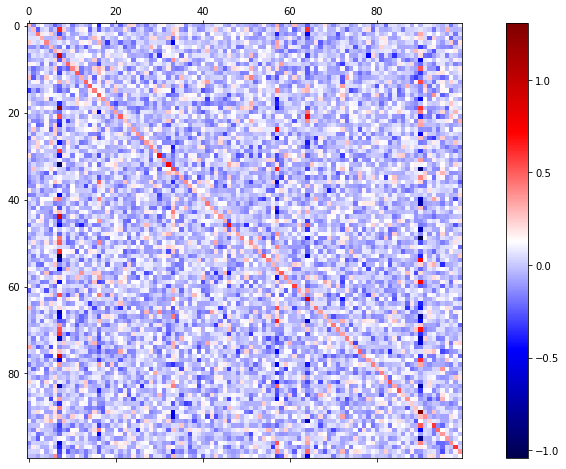

In [25]:
fig, axes = plt.subplots()
min_val, max_val = -2, 2

# define the colormap
cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize and forcing 0 to be part of the colorbar!
bounds = np.arange(np.min(Abar),np.max(Abar),.5)
idx=np.searchsorted(bounds,0)
bounds=np.insert(bounds,idx,0)
norm = BoundaryNorm(bounds, cmap.N)

pos = axes.matshow(Abar[0:100, 0:100], cmap='seismic')
fig.colorbar(pos)